In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
dataset_path = '/content/gdrive/My Drive/quickdraw_small/'

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
from torch import nn, optim
from torchvision import transforms, datasets

In [0]:
from my_ml_lib import MetricTools, PlotTools

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
data_dirs = {
    'train': dataset_path+'train/',
    'valid': dataset_path+'valid/',
    'test': dataset_path+'test/',
}

In [0]:
for d in ['train', 'valid', 'test']:
    os.rmdir(data_dirs[d] + '.ipynb_checkpoints') 

In [9]:
files = os.listdir(data_dirs['train'])
files = files[:10]
idx_to_class = sorted([f.split('_')[-1].split('.')[0] for f in files])

class_to_idx = {idx_to_class[i]: i for i in range(len(idx_to_class))}

len(idx_to_class), class_to_idx, idx_to_class

(10,
 {'airplane': 0,
  'alarm clock': 1,
  'banana': 2,
  'baseball bat': 3,
  'bicycle': 4,
  'car': 5,
  'crown': 6,
  'fish': 7,
  'headphones': 8,
  'pants': 9},
 ['airplane',
  'alarm clock',
  'banana',
  'baseball bat',
  'bicycle',
  'car',
  'crown',
  'fish',
  'headphones',
  'pants'])

In [0]:
data_transforms = {
    'train':transforms.Compose([
            transforms.RandomRotation(10),
            transforms.ToTensor(),
#             transforms.Normalize([0.155], [0.316])
        ]),
    'valid':transforms.Compose([
            transforms.ToTensor(),
#             transforms.Normalize([0.155], [0.316])
        ]),
    'test':transforms.Compose([
            transforms.ToTensor(),
#             transforms.Normalize([0.155], [0.316])
        ])
}

In [0]:
dataset = {}
# mean, std = None, None

for d in ['train', 'valid', 'test']:
    data_x = []
    data_y = []
    for path, _, _temp in os.walk(data_dirs[d]):
        for f in files:
            c = f.split('_')[-1].split('.')[0] # get class name from file name
            x = np.load(path + f).reshape(-1, 28, 28) / 255
            y = np.ones((len(x), 1), dtype=np.int64) * class_to_idx[c]
            
            data_x.extend(x)
            data_y.extend(y)
#     if d == 'train':
#         mean = np.mean(data_x)
#         std = np.std(data_x)
    dataset[d] = torch.utils.data.TensorDataset(torch.stack([data_transforms[d](Image.fromarray(np.uint8(i*255))) for i in data_x]), 
                                                torch.stack([torch.Tensor(j) for j in data_y]))


In [12]:
[len(dataset[d]) for d in ['train', 'valid', 'test']]

[84000, 36000, 30000]

In [0]:
bs = 128 # batch size

In [0]:
dataloaders = {
    d: torch.utils.data.DataLoader(dataset[d], batch_size=bs, shuffle=True) for d in ['train', 
                                                                                      'valid', 
                                                                                      'test']
}

In [0]:
invTrans = transforms.Compose([ transforms.Normalize([0.],[1/0.316]),
                                transforms.Normalize([-0.155],[1.]),
                               ])

def imshow(img):
#     img = invTrans(img)
#     img = img.numpy()
    plt.imshow(img.reshape(28,28), cmap='gray')

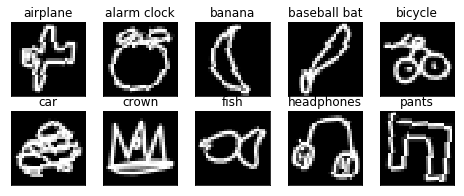

In [0]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

fig = plt.figure(figsize=(8, 3))
# display 9 images
for cls in np.arange(10):
    ax = fig.add_subplot(2, 5, cls+1, xticks=[], yticks=[])
    
    image = images.numpy()[labels.numpy().reshape(-1) == cls][0]
    label = labels.numpy()[labels.numpy().reshape(-1) == cls][0, 0].astype(np.int64)
    imshow(image)
    ax.set_title(idx_to_class[label])
plt.savefig('data_vis_small.png')

In [37]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14x14x5
            nn.Conv2d(5, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 7x7x8
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU() # 7x7x16
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*16, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(100, 10)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out


model_scratch = Net()
model_scratch.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [0]:
criterion_scratch = nn.CrossEntropyLoss()

# optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

In [0]:
def train(n_epochs, loaders, model, optimizer, criterion, device, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_losses = []
    val_losses = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU or CPU
#             print(torch.max(target,1)[0])
            data, target = data.to(device), target.long().to(device)
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss as follows
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, torch.max(target,1)[0])
            
            loss.backward()
            optimizer.step()
            
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU or CPU
            data, target = data.to(device), target.long().to(device)
            
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, torch.max(target,1)[0])
            
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        
        if valid_loss < valid_loss_min:
            print('Saving model..')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
    
    # return trained model
    return model, train_losses, val_losses

In [40]:
# train the model
model_scratch, train_losses, val_losses = train(25, dataloaders, model_scratch, optimizer_scratch, 
                                                criterion_scratch, device, 'model_scratch-25epochs-small.pt')

Epoch: 1 	Training Loss: 0.888627 	Validation Loss: 0.442564
Saving model..
Epoch: 2 	Training Loss: 0.480836 	Validation Loss: 0.331642
Saving model..
Epoch: 3 	Training Loss: 0.383856 	Validation Loss: 0.278752
Saving model..
Epoch: 4 	Training Loss: 0.326465 	Validation Loss: 0.253496
Saving model..
Epoch: 5 	Training Loss: 0.288928 	Validation Loss: 0.236648
Saving model..
Epoch: 6 	Training Loss: 0.263565 	Validation Loss: 0.228176
Saving model..
Epoch: 7 	Training Loss: 0.246785 	Validation Loss: 0.215645
Saving model..
Epoch: 8 	Training Loss: 0.235600 	Validation Loss: 0.212701
Saving model..
Epoch: 9 	Training Loss: 0.223981 	Validation Loss: 0.205885
Saving model..
Epoch: 10 	Training Loss: 0.216250 	Validation Loss: 0.207738
Epoch: 11 	Training Loss: 0.208286 	Validation Loss: 0.200292
Saving model..
Epoch: 12 	Training Loss: 0.198608 	Validation Loss: 0.205331
Epoch: 13 	Training Loss: 0.194282 	Validation Loss: 0.205973
Epoch: 14 	Training Loss: 0.188328 	Validation Loss: 

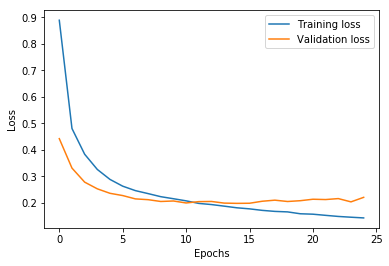

In [41]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xticks([i for i in range(0, len(train_losses), 5)].append(len(train_losses)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
_ = plt.ylim()
# plt.title('Training Validation Loss with CNN from scratch')
# plt.savefig('Training Validation Loss with CNN from scratch-25epochs-small.png')
plt.show()

In [0]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch-25epochs-small.pt'))

In [0]:
def mapk(target, output, k=3):
    map_sum = 0
    output = torch.topk(output, k)[1]
    for i, t in enumerate(target):
        idx = (output[i] == t).nonzero().cpu().numpy()
        if len(idx) == 0:
            continue
            
        idx = idx[0][0]
        map_sum += 1 / (idx + 1)
        
    return map_sum

In [0]:
def test(loaders, model, criterion, device):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    total_mapk = 0
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU or CPU
        data, target = data.to(device), target.long().to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target.view(-1))
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
            probs = output.data.cpu().numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
            probs = np.vstack([probs, output.data.cpu().numpy()])
            
        total_mapk += mapk(target, output)
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    map3 = np.around(total_mapk / len(loaders["test"].dataset) * 100, 2)
    print(f'\nMean Average Precision @ 3: {map3}%')
          
    return y, y_hat, probs

In [45]:
# call test function    
y, y_hat, probs = test(dataloaders, model_scratch, criterion_scratch, device)

Test Loss: 0.200899


Test Accuracy: 94% (28348/30000)

Mean Average Precision @ 3: 95.99%


In [0]:
def cmc_curve(probs, y, idx_to_class):
    counts = np.zeros(len(idx_to_class))
    
    indices = np.argsort(probs * -1)
    for i in range(y.shape[0]):
        actual = y[i]
        rank = 1
        for pred in indices[i]:
            if pred == actual:
                break
            rank += 1
        
        counts[rank - 1] += 1
    
    ranks = np.zeros(len(idx_to_class))
    ranks[0] = counts[0]
    for i in range(1, len(idx_to_class)):
        ranks[i] = ranks[i-1] + counts[i]

    return ranks / y.shape[0]

In [0]:
cmcs = cmc_curve(probs, y, idx_to_class)

In [0]:
cmcs_lda_3 = [0.91458333, 0.95911111, 0.97458333, 0.98288889, 0.98794444, 0.99166667,
 0.99483333, 0.99686111, 0.99872222, 1.]

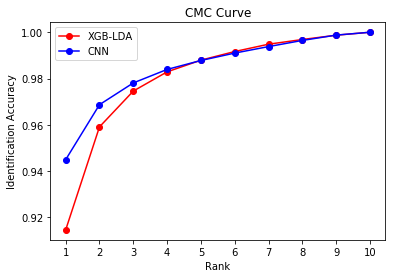

In [68]:
plt.plot([i for i in range(1,11)], cmcs_lda_3, 'bo-', label='XGB-LDA', c='r')
plt.plot([i for i in range(1,11)], cmcs, 'bo-', label='CNN')
plt.locator_params(axis='x', nbins=10)
plt.xlabel('Rank')
plt.ylabel('Identification Accuracy')
plt.title('CMC Curve')
plt.legend()
plt.savefig('cmc_small.png')
plt.show()

In [60]:
MetricTools.accuracy(y, y_hat)

0.9449333333333333

In [0]:
cm = MetricTools.confusion_matrix(y, y_hat, nclasses=len(idx_to_class))

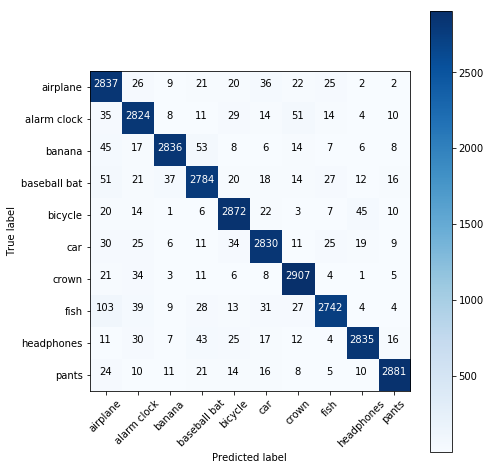

In [62]:
PlotTools.confusion_matrix(cm, idx_to_class, title='',
                           filename='Confusion Matrix with CNN from scratch-25-small', figsize=(7,7), path='./')

In [0]:
prec, rec = MetricTools.prec_recall(y, y_hat, len(idx_to_class))
f1 = 1 /(0.5 * (1/prec + 1/rec))

In [64]:
np.around([prec, rec, f1], 3)

array([0.945, 0.945, 0.945])